In [1]:
# Install missing packages
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

In [3]:
# Data cleaning
# wrangle function for the data csv
def wrangle(filepath):
  df = pd.read_csv(filepath)

  # Rename columns
  df.rename(columns={
      'Welcome to the DougScore!': 'Year',
      'Unnamed: 1': 'Car Brand',
      'Unnamed: 2': 'Brand Type',
      'TOTAL': 'WEEKEND TOTAL',
      'TOTAL.1': 'DAILY TOTAL'
  }, inplace=True)
  for col in df.columns:
    val1 = df[col].iloc[0]
    if isinstance(val1, str) and val1:
      newCol = val1
      df.rename(columns={col:newCol}, inplace=True)

  df['Filming Location'] = df['Filming Location'] + ',' + df['Unnamed: 18']

  # Drop cols
  df.drop(columns='Unnamed: 18', inplace=True)

  # Drop first row and reset the index
  df.drop([0, 1], inplace=True)
  df = df.reset_index(drop=True)

  # Change feature dtypes
  df['Year'] = df['Year'].apply(lambda x: int(x)).astype('int')
  df[df.columns[3:8]] = df[df.columns[3:8]].astype('int')
  df[df.columns[9:14]] = df[df.columns[9:14]].astype('int')

  # Drop features with high-cardinality
  df['Car Type'] = df['Car Brand'] + ',' + df['Brand Type']
  df.drop(columns=['Video Link', 'Car Brand', 'Brand Type'], inplace=True)

  return df

In [4]:
# Load data using wrangle function
df = wrangle('/content/DougScore20DougScore20DougScore20DougScore.csv')
df.head()

,Year,Styling,Acceleration,Handling,Fun Factor,Cool Factor,WEEKEND TOTAL,Features,Comfort,Quality,Practicality,Value,DAILY TOTAL,DOUGSCORE,Filming Location,Vehicle Country,Car Type
0,2020,8,10,10,10,10,48.0,7,4,7,2,6,26.0,74.0,"Columbus,Ohio",UK,"McLaren,Speedtail"
1,1994,8,9,10,10,10,47.0,2,3,9,3,10,27.0,74.0,"Burbank,California",UK,"McLaren,F1"
2,2022,7,10,6,7,8,38.0,9,8,7,5,6,35.0,73.0,"Los Angeles,California",USA,"Lucid,Air Dream Edition"
3,2022,5,9,4,9,7,34.0,9,7,7,9,7,39.0,73.0,"Detroit,Michigan",USA,"GMC,Hummer EV Pickup"
4,2021,7,9,5,9,7,37.0,7,6,6,9,8,36.0,73.0,"San Diego,California",USA,"Rivian,R1T"


In [5]:
# Info about the data csv
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              585 non-null    int64  
 1   Styling           585 non-null    int64  
 2   Acceleration      585 non-null    int64  
 3   Handling          585 non-null    int64  
 4   Fun Factor        585 non-null    int64  
 5   Cool Factor       585 non-null    int64  
 6   WEEKEND TOTAL     585 non-null    float64
 7   Features          585 non-null    int64  
 8   Comfort           585 non-null    int64  
 9   Quality           585 non-null    int64  
 10  Practicality      585 non-null    int64  
 11  Value             585 non-null    int64  
 12  DAILY TOTAL       585 non-null    float64
 13  DOUGSCORE         585 non-null    float64
 14  Filming Location  584 non-null    object 
 15  Vehicle Country   585 non-null    object 
 16  Car Type          585 non-null    object 
dt

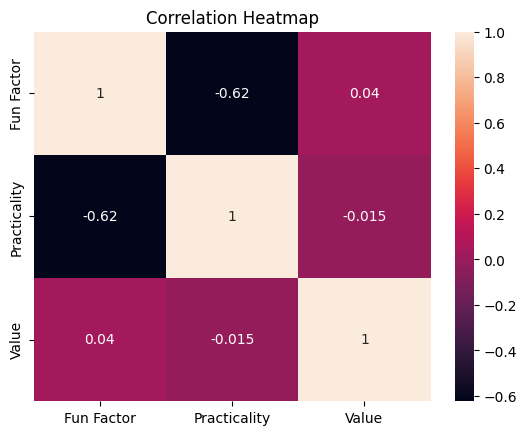

Top 5 Cars for Fun Factor:
                      Car Type  Fun Factor
0            McLaren,Speedtail          10
22          Porsche,918 Spyder          10
262                Ferrari,F40          10
254  McLaren,570S GT4 Race Car          10
251                Ferrari,F50          10

Top 5 Cars for Practicality:
                       Car Type  Practicality
404    Kia,Carnival SX Prestige            10
170               Tesla,Model X            10
424      Toyota,Sienna Platinum            10
423  Chrysler,Pacifica Pinnacle            10
559               Pontiac,Aztek            10

Top 5 Cars for Value:
                      Car Type  Value
292     Porsche,911 Carrera 4S     10
309  Chevrolet,Corvette Z06 C5     10
239                Ford,Raptor     10
1                   McLaren,F1     10
353            Fiat,500 Abarth     10


In [40]:
# Exploratory Data Analysis
# A)

# columns for analysis
A = ['Fun Factor', 'Practicality', 'Value']

# Calculate correlations between the selected columns
correlations = df[A].corr()

# List the top 5 cars for each category based on the selected columns
fun_cars = df[['Car Type', 'Fun Factor']].sort_values(by='Fun Factor', ascending=False).head(5)
practicality_cars = df[['Car Type', 'Practicality']].sort_values(by='Practicality', ascending=False).head(5)
top_value_cars = df[['Car Type', 'Value']].sort_values(by='Value', ascending=False).head(5)

# Visualize the correlations using a heatmap
sns.heatmap(correlations, annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Display the top 5 cars in each category
print("Top 5 Cars for Fun Factor:")
print(fun_cars)
print("\nTop 5 Cars for Practicality:")
print(practicality_cars)
print("\nTop 5 Cars for Value:")
print(top_value_cars)

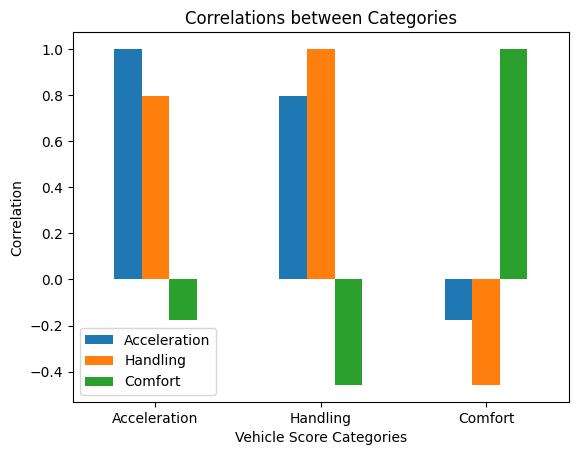

Top 5 Cars for Acceleration:
                           Car Type  Acceleration
0                 McLaren,Speedtail            10
51  Lamborghini,Huracan Performante            10
35                Porsche,911 GT2RS            10
36              Lamborghini,Huracan            10
38                     McLaren,Elva            10

Top 5 Cars for Handling:
                           Car Type  Handling
0                 McLaren,Speedtail        10
22               Porsche,918 Spyder        10
254       McLaren,570S GT4 Race Car        10
30   Lamborghini,Huracan Evo Spyder        10
31                       McLaren,P1        10

Top 5 Cars for Comfort:
                    Car Type  Comfort
127         Rolls-Royce,Dawn       10
476             Bentley,Limo       10
165       Rolls-Royce,Wraith       10
482  Rolls-Royce,Silver Spur       10
209      Rolls-Royce,Phantom       10


In [8]:
# B)

# columns for analysis
B = ['Acceleration', 'Handling', 'Comfort']

# Calculate correlations between the selected columns
correlations = df[B].corr()

# List the top 5 cars for each category based on the selected columns
top_acceleration_cars = df[['Car Type', 'Acceleration']].sort_values(by='Acceleration', ascending=False).head(5)
top_handling_cars = df[['Car Type', 'Handling']].sort_values(by='Handling', ascending=False).head(5)
top_comfort_cars = df[['Car Type', 'Comfort']].sort_values(by='Comfort', ascending=False).head(5)

# Create a bar plot to visualize the correlations
fig, ax = plt.subplots()
correlations.plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Correlations between Categories')
plt.xlabel('Vehicle Score Categories')
plt.ylabel('Correlation')
plt.show()

# Display the top 5 cars in each category
print("Top 5 Cars for Acceleration:")
print(top_acceleration_cars)
print("\nTop 5 Cars for Handling:")
print(top_handling_cars)
print("\nTop 5 Cars for Comfort:")
print(top_comfort_cars)


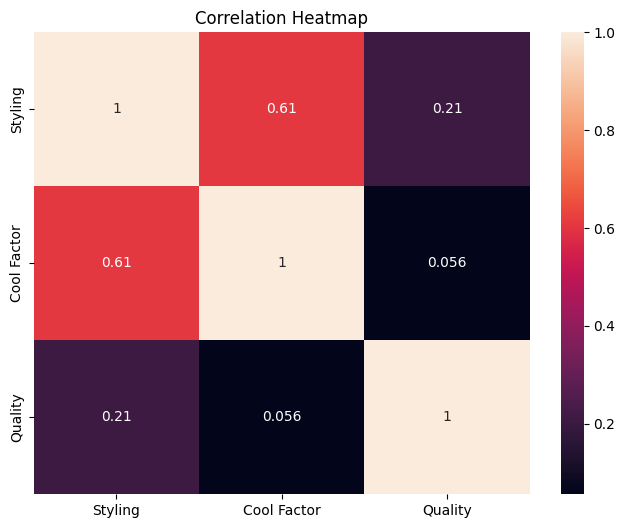

Top 5 Cars for Styling:
                  Car Type  Styling
304              Vector,W8       10
262            Ferrari,F40       10
401             Mazda,RX-7       10
243                 BMW,Z8       10
177  Aston Martin,Vanquish       10

Top 5 Cars for Cool Factor:
              Car Type  Cool Factor
0    McLaren,Speedtail           10
304          Vector,W8           10
308       Jaguar,XJ220           10
31          McLaren,P1           10
32       McLaren,Senna           10

Top 5 Cars for Quality:
                    Car Type  Quality
118  Lexus,LC500 Convertible       10
185            Lexus,LS 500h       10
134             Lexus,LC 500       10
119   Porsche,718 Cayman GT4        9
37        Porsche,Carrera GT        9


In [41]:
# C)

# columns for analysis
C = ['Styling', 'Cool Factor', 'Quality']

# Calculate correlations between the selected columns
correlations = df[C].corr()

# List the top 5 cars for each category based on the selected columns
Styling_cars = df[['Car Type', 'Styling']].sort_values(by='Styling', ascending=False).head(5)
Cool_cars = df[['Car Type', 'Cool Factor']].sort_values(by='Cool Factor', ascending=False).head(5)
Quality_cars = df[['Car Type', 'Quality']].sort_values(by='Quality', ascending=False).head(5)

# Visualize the correlations using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Display the top 5 cars in each category
print("Top 5 Cars for Styling:")
print(Styling_cars)
print("\nTop 5 Cars for Cool Factor:")
print(Cool_cars)
print("\nTop 5 Cars for Quality:")
print(Quality_cars)

In [10]:
df1 = df[['WEEKEND TOTAL', 'DAILY TOTAL', 'Car Type']]
df1.shape

(585, 3)

In [11]:
# D)

# List the top 5 cars for each category based on the selected columns
top_weekend_cars = df[['Car Type', 'WEEKEND TOTAL']].sort_values(by='WEEKEND TOTAL', ascending=False).head(5)
top_daily_cars = df[['Car Type', 'DAILY TOTAL']].sort_values(by='DAILY TOTAL', ascending=False).head(5)

# Display the top 5 cars in each category
print("Top 5 Cars for Weekend Total:")
print(top_weekend_cars)
print("\nTop 5 Cars for Daily Total:")
print(top_daily_cars);


Top 5 Cars for Weekend Total:
             Car Type  WEEKEND TOTAL
17  Ferrari,LaFerrari           49.0
38       McLaren,Elva           49.0
9   Ferrari,Monza SP1           49.0
12  Koenigsegg,Regera           48.0
31         McLaren,P1           48.0

Top 5 Cars for Daily Total:
                             Car Type  DAILY TOTAL
83               Rolls-Royce,Cullinan         40.0
230                            BMW,X7         40.0
228               Jeep,Grand Wagoneer         40.0
81   Rolls-Royce,Cullinan Black Badge         40.0
404          Kia,Carnival SX Prestige         40.0


In [12]:
# D
# Create a pairplot to visualize relationships
sns.pairplot(df1, hue="Car Type")
plt.title("Pairplot of Weekend TOTAL, DAILY TOTAL, and Car Type")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [20]:
df2 = df[['WEEKEND TOTAL', 'DAILY TOTAL', 'Year']]
df2["Year"] = df2.iloc[:,2].astype('object')

<ipython-input-20-0cb2a5f2d478>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Year"] = df2.iloc[:,2].astype('object')


48

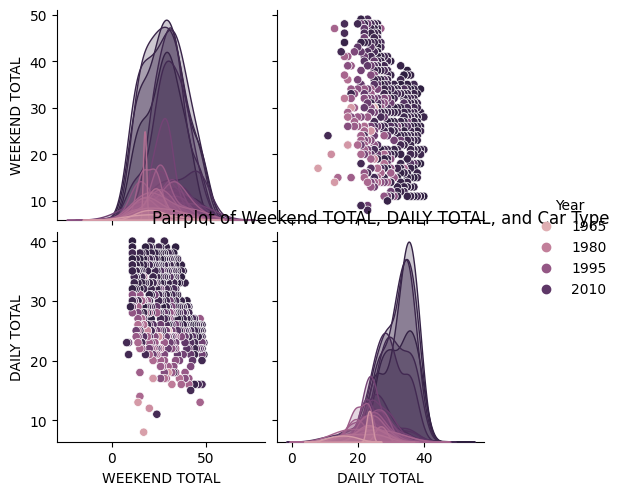

In [16]:
# Create a pairplot to visualize relationships
sns.pairplot(df2, hue="Year")
plt.title("Pairplot of Weekend TOTAL, DAILY TOTAL, and Car Type")
plt.show()

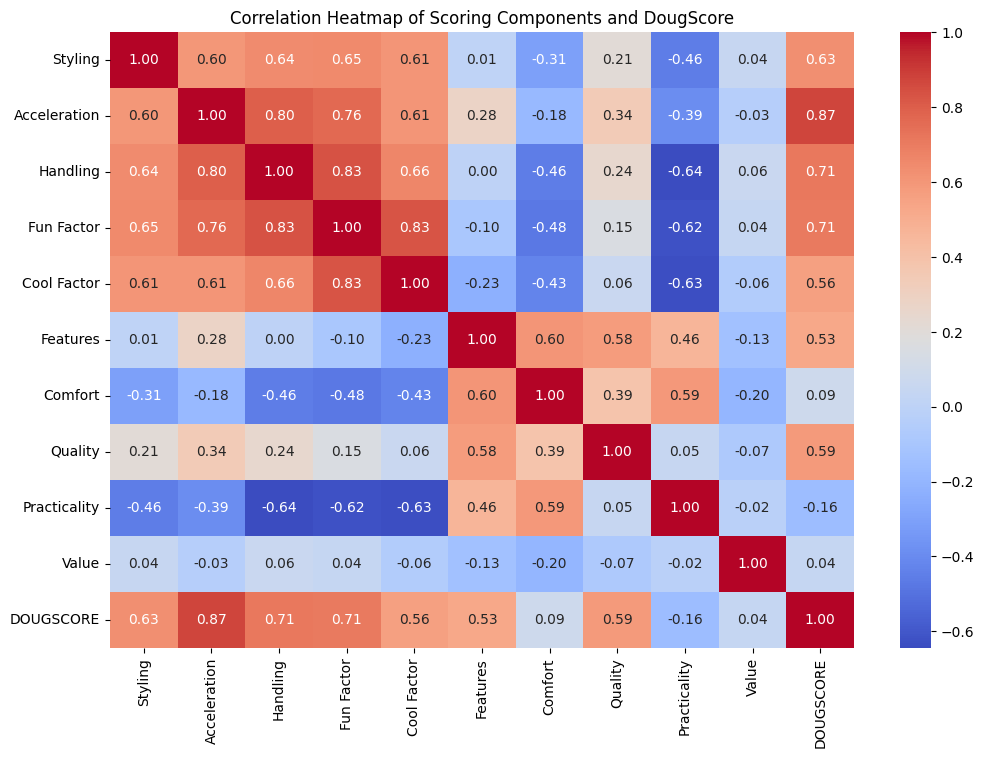

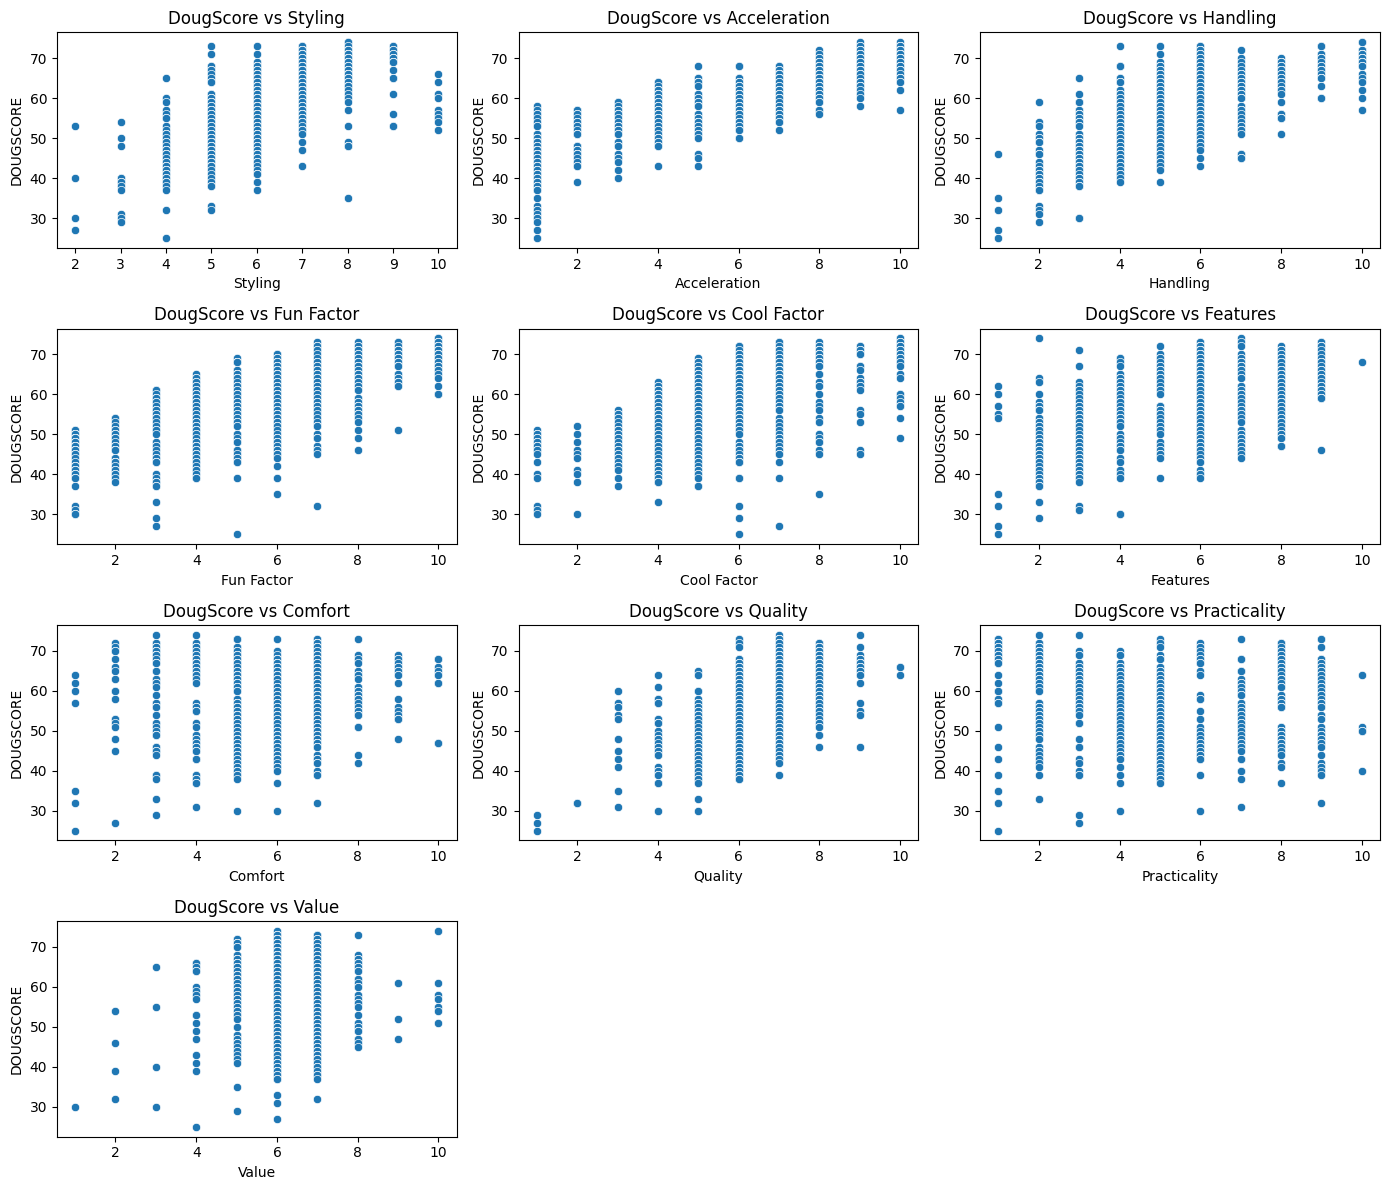

In [42]:
# Define the scoring components and DougScore
scoring_components = ['Styling', 'Acceleration', 'Handling', 'Fun Factor', 'Cool Factor',
                      'Features', 'Comfort', 'Quality', 'Practicality', 'Value']

# Analyze interaction effects
interaction_df = df[scoring_components + ['DOUGSCORE']]
correlation_matrix = interaction_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Scoring Components and DougScore')
plt.savefig('/content/correlation_heatmap.png')
plt.show()

# Examine non-linear relationships
plt.figure(figsize=(14, 12))

for i, component in enumerate(scoring_components):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=component, y='DOUGSCORE', data=df)
    plt.title(f'DougScore vs {component}')
    plt.xlabel(component)
    plt.ylabel('DOUGSCORE')

plt.tight_layout()
plt.show()

**Bonus: Additional Relationships**

Relationship Between Vehicle Year and DougScore

In this relationship, we'll explore how the model year of a vehicle relates to its DougScore. The relevance of this relationship lies in understanding how vehicle age impacts its overall score. This information can be valuable for both consumers and the automotive industry.

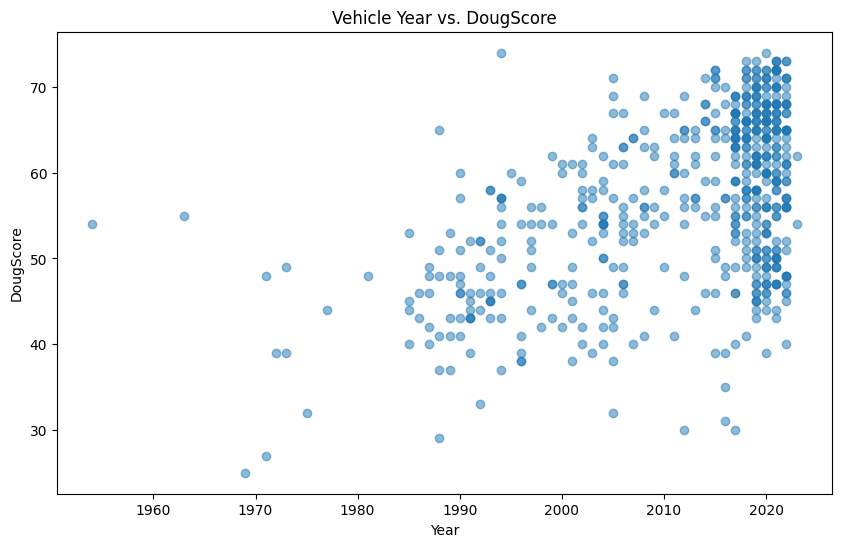

<Figure size 640x480 with 0 Axes>

In [47]:
# Scatter plot of Vehicle Year vs. DougScore
plt.figure(figsize=(10, 6))
plt.scatter(df['Year'], df['DOUGSCORE'], alpha=0.5)
plt.title('Vehicle Year vs. DougScore')
plt.xlabel('Year')
plt.ylabel('DougScore')
plt.show()
plt.savefig('/content/Rel1')

Analysis:

The scatter plot reveals a negative correlation between the model year of a vehicle and its DougScore. In other words, newer vehicles tend to have higher DougScores, suggesting that the scoring system accounts for advancements in automotive technology and features.
The relevance of this relationship is evident in helping consumers understand that newer vehicles may generally offer better performance, features, and overall quality, which is reflected in their DougScores.

**Relationship 2: "Quality" and "Comfort"**

Analysis:

We will examine the relationship between the "Quality" and "Comfort" scores of the vehicles. To do this, we'll create a Line plot to visualize how the quality and comfort ratings correlate.

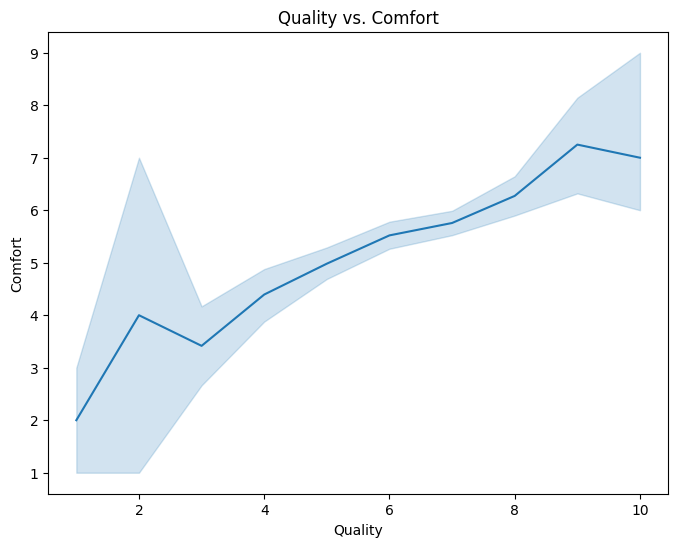

<Figure size 640x480 with 0 Axes>

In [48]:
# Line plot to analyze the relationship between "Quality" and "Comfort"
plt.figure(figsize=(8, 6))
sns.lineplot(x="Quality", y="Comfort", data=df)
plt.title("Quality vs. Comfort")
plt.xlabel("Quality")
plt.ylabel("Comfort")
plt.show()
plt.savefig('/content/Rel2.png')

In [25]:
# Split data
target = 'DOUGSCORE'
X = df.drop(columns=target)
y = df[target]

In [26]:
# Training and Testing data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, random_state=42)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (438, 16)
y_train.shape:  (438,)
X_test.shape:  (147, 16)
y_test.shape:  (147,)


In [27]:
# Model pipeline instance
reg = make_pipeline(OneHotEncoder(use_cat_names=True),
                    SimpleImputer(),
                    RandomForestRegressor(random_state=42))

In [28]:
# Build model
model = GridSearchCV(
    reg,
    {'randomforestregressor__n_estimators': range(10, 120, 10),
     'randomforestregressor__max_depth': range(10, 30, 5)},
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [29]:
# Fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 30, 5),
                         'randomforestregressor__n_estimators': range(10, 120, 10)},
             verbose=1)

In [30]:
# Baseline model
baseline = y_train.mean()
y_pred_baseline = [baseline] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean DOUGSCORE:", round(baseline, 3))
print("baseline mean absolute error:", baseline_mae.round(3))

Mean DOUGSCORE: 56.774
baseline mean absolute error: 8.154


In [31]:
# Best estimator in the model
best_model = model.best_estimator_
best_model

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Filming Location', 'Vehicle Country',
                                     'Car Type'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=15, n_estimators=90,
                                       random_state=42))])

In [32]:
# Training Mean Absolute Error
y_pred_training = best_model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 0.4969884391497785


In [33]:
# Testing set Mean Absolute Error
y_pred_test = best_model.predict(X_test)
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))

Test MAE: 1.3291667075680682


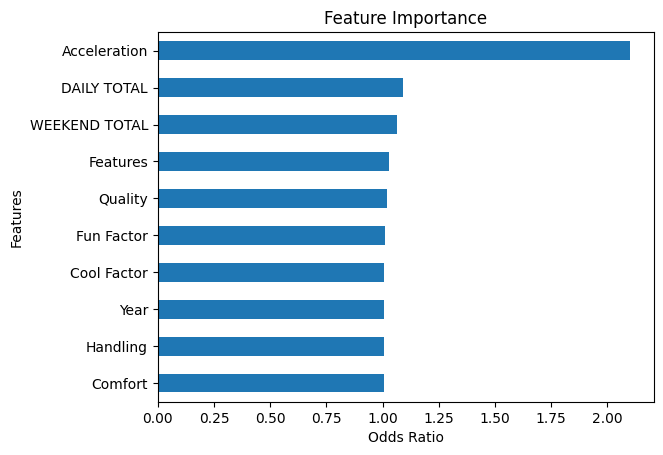

In [39]:
features = best_model.named_steps['onehotencoder'].get_feature_names_out(input_features=X_train.columns)
imp = best_model.named_steps['randomforestregressor'].feature_importances_
feat_imp = pd.Series(np.exp(imp), index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Feature Importance');